In [4]:
#Imports and Setup

import os
import pandas as pd
import numpy as np
import sys
sys.path.append('../scripts')
from utils import make_project_dirs, save_histplot, save_boxplot, save_figure


# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure outputs/figures folders exist
make_project_dirs()

In [5]:
#Load Data

DATA_PATH = '../data/pollution_us_2000_2016.csv'   # Adjust path if running from project root

df = pd.read_csv(DATA_PATH)
df.head()

,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0
4,4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,...,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN


In [6]:
#EDA - Structure & Missing Values

print(df.info())
print(df.describe())
print(df.isnull().sum())

# Optional: Save missing values as CSV for report
df.isnull().sum().to_csv('outputs/missing_values_summary.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1746661 entries, 0 to 1746660
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   State Code         int64  
 2   County Code        int64  
 3   Site Num           int64  
 4   Address            object 
 5   State              object 
 6   County             object 
 7   City               object 
 8   Date Local         object 
 9   NO2 Units          object 
 10  NO2 Mean           float64
 11  NO2 1st Max Value  float64
 12  NO2 1st Max Hour   int64  
 13  NO2 AQI            int64  
 14  O3 Units           object 
 15  O3 Mean            float64
 16  O3 1st Max Value   float64
 17  O3 1st Max Hour    int64  
 18  O3 AQI             int64  
 19  SO2 Units          object 
 20  SO2 Mean           float64
 21  SO2 1st Max Value  float64
 22  SO2 1st Max Hour   int64  
 23  SO2 AQI            float64
 24  CO Units           object 
 25  CO Mean           

In [7]:
#Data Cleaning

# Drop columns with excessive missing data, or fill if appropriate
df = df.dropna(subset=["O3 Mean", "CO Mean", "NO2 Mean", "SO2 Mean"])
df = df.copy()  # Prevent SettingWithCopyWarning

# Convert 'Date Local' to datetime
df['Date Local'] = pd.to_datetime(df['Date Local'])

# Save cleaned sample for report
df.sample(100).to_csv('outputs/cleaned_sample.csv', index=False)

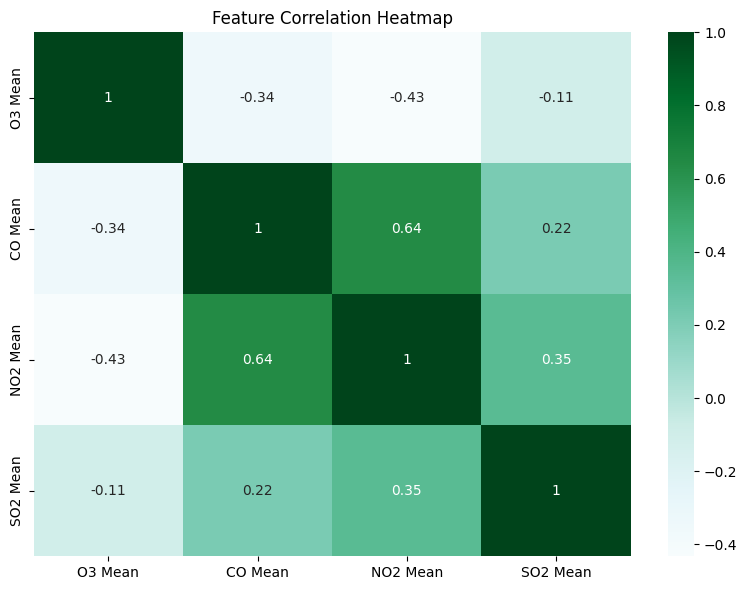

In [8]:
#EDA Visualizations

save_histplot(df["O3 Mean"], "Ozone (O3) Mean Distribution", "o3_mean_distribution")
save_histplot(df["CO Mean"], "CO Mean Distribution", "co_mean_distribution")
save_histplot(df["NO2 Mean"], "NO2 Mean Distribution", "no2_mean_distribution")
save_histplot(df["SO2 Mean"], "SO2 Mean Distribution", "so2_mean_distribution")

save_boxplot(df["O3 Mean"], "Ozone (O3) Mean Boxplot", "o3_mean_boxplot")
save_boxplot(df["CO Mean"], "CO Mean Boxplot", "co_mean_boxplot")
save_boxplot(df["NO2 Mean"], "NO2 Mean Boxplot", "no2_mean_boxplot")
save_boxplot(df["SO2 Mean"], "SO2 Mean Boxplot", "so2_mean_boxplot")

# Show correlation heatmap in notebook (save manually if desired)
plt.figure(figsize=(8,6))
sns.heatmap(df[["O3 Mean", "CO Mean", "NO2 Mean", "SO2 Mean"]].corr(), annot=True, cmap="BuGn")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("outputs/figures/eda/feature_correlation_heatmap.png")
plt.show()

In [9]:
#Feature/Target Engineering

# Create target and features using valid columns only
df['Ozone_High'] = (df['O3 Mean'] > 0.070).astype(int)
features = ["CO Mean", "NO2 Mean", "SO2 Mean"]
target = "Ozone_High"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
#Train and Evaluate Classifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# ROC/AUC
y_proba = clf.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", roc_auc)

# ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax)
save_figure(fig, "model_eval", "random_forest_roc_curve")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523849
           1       0.96      0.31      0.46       150

    accuracy                           1.00    523999
   macro avg       0.98      0.65      0.73    523999
weighted avg       1.00      1.00      1.00    523999

[[523847      2]
 [   104     46]]
ROC AUC: 0.9731805921171942


In [11]:
#Cross-validation

cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", cv_scores)
print("Mean CV AUC:", np.mean(cv_scores))

Cross-validated AUC scores: [0.50036102 0.51642881 0.52254644 0.53372849 0.53471958]
Mean CV AUC: 0.5215568691606282


C:\Users\Jacob\AppData\Local\Temp\ipykernel_10468\2830367733.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_df, palette="BuGn_d")


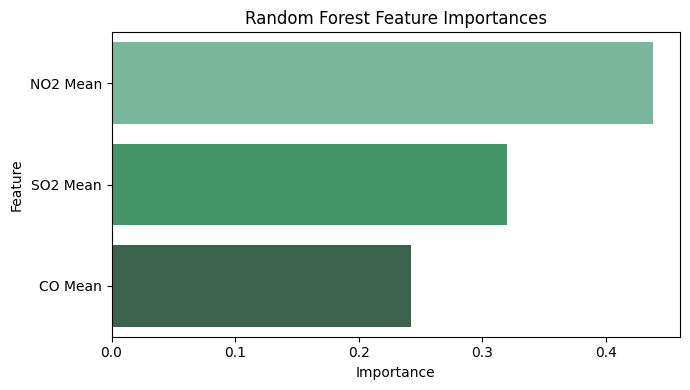

In [12]:
#Feature Importances

importances = clf.feature_importances_
feat_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values("Importance", ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(x="Importance", y="Feature", data=feat_df, palette="BuGn_d")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.savefig("outputs/figures/model_eval/feature_importance.png")
plt.show()